# Intensity Profiles
This notebook contains the steps done to compute the surface brightness profiles of our galaxy. We used astropy to fit a de Vaucouleurs and an Exponential fit and compared their fit to found brightness profiles.

### Setup
We import the libraries needed and we load the data from the data disk. We also apply a scaling factor to convert our semi-major axis to arcsecs. We also do the conversions necessary to convert counts to mag arcsec$^{-2}$

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling import models, fitting
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.table import Table

data_dir = "/net/virgo01/data/users/tboersma/2025-04-30/intensity_profiles/"

csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv") and 'iso' in f]

# Read and concatenate
df_list = []
for f in csv_files:
    fp = os.path.join(data_dir, f)
    try:
        df = pd.read_csv(fp)
        df['filter'] = f.split("_")[-1].replace(".csv", "")
        df_list.append(df)
    except Exception as e:
        print(f"Skipping {f} due to error: {e}")

ellipse_df = pd.concat(df_list, ignore_index=True)

scaling = 0.800915
ellipse_df['sma'] *= scaling

# load sols from csv generated by StandardStars.ipynb
df = pd.read_csv(f"{data_dir}/calibration_solutions.csv", index_col=0)
sols = {filt: (row.ZP, row.ct) for filt, row in df.iterrows()}

# build manual TAN-WCS centered on M81
pixscale = 0.5

hdu   = fits.open(f"{data_dir}/M81_stamp_R*.fits")[0]
ny,nx = hdu.data.shape
xc,yc = nx/2, ny/2
w     = WCS(naxis=2)
w.wcs.crpix = [xc, yc]
w.wcs.crval = [148.888244, 69.065291]
cd        = pixscale/3600.0
w.wcs.cd   = [[ cd, 0 ], [ 0, -cd ]]
w.wcs.ctype = ["RA---TAN","DEC--TAN"]
sky_ctr    = pixel_to_skycoord(xc, yc, w)

sma   = ellipse_df['sma']
intens = ellipse_df['intens']
ellipse_df['mu'] = ellipse_df['filter'].map(lambda x: sols[x[0]][0]) - 2.5*np.log10(intens) + 2.5*np.log10(pixscale**2)

mu_err = np.full_like(ellipse_df['intens'], np.nan, dtype=float)
ellipse_df['mu_err'] = (2.5 / np.log(10)) * (ellipse_df['intens_err'] / ellipse_df['intens']) 

sky   = pixel_to_skycoord(xc+sma, yc, w)
ellipse_df['sma_sky'] = sky_ctr.separation(sky).arcsec

print(ellipse_df)

     Unnamed: 0         sma       intens  intens_err  ellipticity  \
0             0    0.000000  4942.248931    0.000000     0.000000   
1             1    0.417266  4903.408992    2.508326     0.510847   
2             2    0.458993  4898.181112    2.724257     0.510565   
3             3    0.504892  4892.280497    2.929649     0.508204   
4             4    0.555381  4880.472360    2.687884     0.456400   
..          ...         ...          ...         ...          ...   
226          72  362.488167    34.203183    0.158717     0.568714   
227          73  398.736983    22.320773    0.110074     0.418259   
228          74  438.610682    16.607854    0.084293     0.361944   
229          75  482.471750    14.198662    0.075118     0.400893   
230          76  530.718925    10.924934    0.069523     0.400893   

     ellipticity_err          pa    pa_err        grad  grad_error  ...  \
0           0.000000    0.000000  0.000000    0.000000         NaN  ...   
1           0.070908 

### Useful Functions and Constants
This code block contains some useful functions and constants for plotting our data. The find_half_light function is used to find a reasonable starting radius for the model fits. The idea is we sum the intensity cumulatively and find the total, the half-light radius is where this sum is half of the total. 

In [2]:
arcsec_to_rad = np.deg2rad(1/3600)
D_pc = 3.675e6  # pc
scale_pc = arcsec_to_rad * D_pc

def arcsec_to_pc(x):
    return x * scale_pc

def pc_to_arcsec(x):
    return x / scale_pc

def log_arcsec_to_log_pc(x):
    return np.log(arcsec_to_pc(np.exp(x)))  # exp to get back to linear arcsec, then convert

def log_pc_to_log_arcsec(x):
    return np.log(pc_to_arcsec(np.exp(x)))  # exp to get back to linear pc, then convert

def count_to_mag(count, ZP):
    return ZP - 2.5 * np.log10(count) + 2.5 * np.log10(pixscale**2)

colors = {"B*" : "blue",
             "G*" : "green",
             "R*" : "red"}
markers = {"B*": "o", "G*": "s", "R*": "D"} 

def find_half_light(df):
    cumulative = np.cumsum(df['intens'].values)
    total = cumulative[-1]
    half_total = total / 2
    idx = np.searchsorted(cumulative, half_total)
    return df['intens'].iloc[idx], df['sma'].iloc[idx]
    


### Surface Brightness Profile
We create a surface brightness profile plot with each of the bands. This plot is quite simple to construct. We need to be aware to use a logarithmic scale. We can otherwise plot the data from the isophote directly.

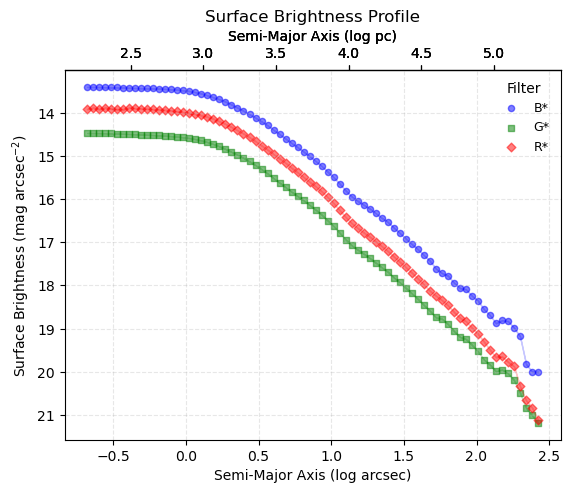

In [3]:
for fil in ellipse_df['filter'].unique():
    # Get data and filter 0 for log10
    fil_df = ellipse_df[ellipse_df['filter'] == fil]
    valid = (fil_df['sma'] > 0) & (fil_df['intens'] > 0) & (fil_df['intens_err'] > 0)
    fil_df = fil_df[valid]
    
    sma = np.log10(fil_df['sma_sky'])
    intens = fil_df['mu']
    intens_err_low = intens - fil_df['mu_err']
    intens_err_high = intens + fil_df['mu_err']
    
    plt.scatter(sma, intens, s=20, color=colors[fil], marker=markers[fil], label=fil, alpha=0.5)
    plt.fill_between(
        sma,
        intens_err_low,
        intens_err_high,
        alpha=0.2, color=colors[fil]
    )
    
    plt.xlabel("Semi-Major Axis (log arcsec)", fontsize=10, fontweight='normal')
    plt.ylabel(r"Surface Brightness (mag arcsec$^{-2}$)")
    plt.gca().invert_yaxis()
    sec = plt.gca().secondary_xaxis('top', functions=(log_arcsec_to_log_pc, log_pc_to_log_arcsec))
    sec.set_xlabel("Semi-Major Axis (log pc)", fontsize=10, fontweight='normal')
    sec.tick_params(axis='x', labelsize=10)
    
plt.title("Surface Brightness Profile")
plt.legend(title="Filter", frameon=False, loc='best', fontsize=9, title_fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

### Position Angle
Here we compute a plot of Position Angle over SMA. We can observe that near the center is a bit chaotic, this is due to the fact that at the very core of the galaxy the position angle is a bit hard to observe. This can be seen from all three bands having wildly different values with large errors. As the SMA increases the fit improves and becomes more stable, the PA stablizes around 120$^{\circ}$. As we get further out and the galaxy becomes fainter, we see that the spirals are slightly tilted compared to the center causing the PA to be lower there. This is probably due to the fact we are not looking at the galaxy exactly head on.

/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


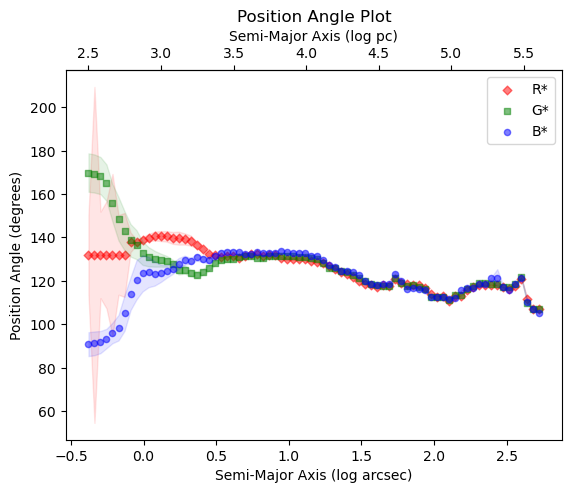

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Position Angle Plot")
plt.xlabel("Semi-Major Axis (log arcsec)")
plt.ylabel("Position Angle (degrees)")
sec = plt.gca().secondary_xaxis('top', functions=(log_arcsec_to_log_pc, log_pc_to_log_arcsec))
sec.set_xlabel("Semi-Major Axis (log pc)", fontsize=10, fontweight='normal')

for fil in set(ellipse_df['filter']):
    fil_df = ellipse_df.loc[ellipse_df['filter'] == fil]
    
    plt.scatter(np.log10(fil_df["sma"]), fil_df["pa"], marker=markers[fil], s=20, alpha=0.5, label=fil, color=colors[fil])
    
    
    
    plt.fill_between(np.log10(fil_df["sma"]), fil_df["pa"] - fil_df["pa_err"],
                     fil_df["pa"] + fil_df["pa_err"], alpha=0.1, color = colors[fil])
plt.legend()
plt.show()

### Ellipticity
Here we compute a plot of Ellipticity over SMA. We can observe that near the center is a bit chaotic, this is due to the fact that at the very core of the galaxy the elipticity is a bit hard to observe. However, afterwars we see it start around 0.3 and increase to around 0.5, reflecting the galaxy getting slightly more eliptical as we look further from the center.

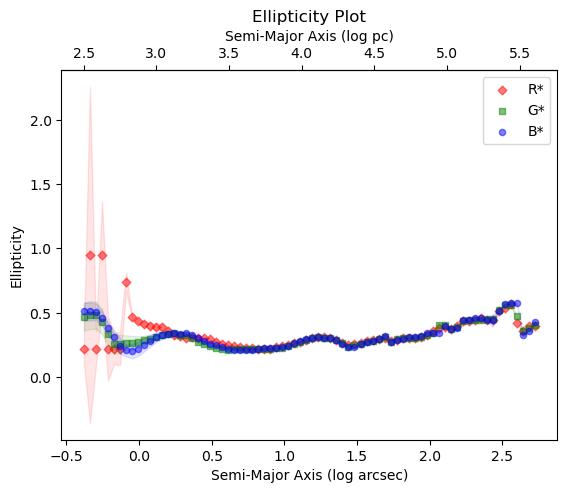

In [5]:
plt.figure()
plt.xlabel("Semi-Major Axis (log arcsec)")
plt.ylabel("Ellipticity")
plt.title("Ellipticity Plot")
sec = plt.gca().secondary_xaxis('top', functions=(log_arcsec_to_log_pc, log_pc_to_log_arcsec))
sec.set_xlabel("Semi-Major Axis (log pc)", fontsize=10, fontweight='normal')

for fil in set(ellipse_df['filter']):
    fil_df = ellipse_df.loc[ellipse_df['filter'] == fil]
    
    plt.scatter(np.log10(fil_df["sma"]), fil_df["ellipticity"], marker=markers[fil], s=20, alpha=0.5, label=fil, color=colors[fil])
    
    plt.fill_between(np.log10(fil_df["sma"]), fil_df["ellipticity"] - fil_df["ellipticity_err"],
                     fil_df["ellipticity"] + fil_df["ellipticity_err"], alpha=0.1, color=colors[fil])
plt.legend()
plt.show()

### Model Fitting
We decide to focus on the R* band for our analysis of the isophotes. This is often used for computing the radius, had better fits and was the brightest overall. 

We used a least squares fit, to optimize our model. The models used were both Sersic1D with n=1 and n=4 for the exponential and de Vaucouleurs fit respectively. We fixed the models n parameter as otherwise we could not fairly compare the two models. When plotting the model we can see the de Vaucouleurs model provides better results. When inspecting the residuals plot we can confirm, both fit about equally well at the start, until the exponential model shoots off.

Note that in the plot we convert the models outputs back to magnitudes, but they were tuned on the counts directly. 

#### Values
As you could see from the figure above we found the following values

Exponential: $h = 0.10 \pm 0.15$ arcsec

Exponential: $h = 1.78 \pm 2.74$ pc

de Vaucouleurs: $R_\text{eff} = 366.16 \pm 0.15$ arcsec

de Vaucouleurs: $R_\text{eff} = 6523.80 \pm 2.74$ pc

We can observe that the better estimate of the effective radius is given by de Vaucouleurs. We can compare this value to the literature. 

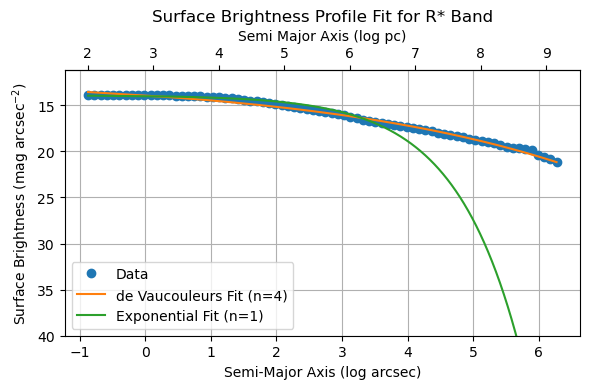

de Vaucoulers MAE: 0.19015181244304447
Fitted de Vaucoulers I_e (amplitude): 21.97
Fitted de Vaucoulers R_e (scale length): 366.16
Fitted de Vaucoulers R_e (scale length, pc): 6523.80
Exponential MAE: 4.822265362944376
Fitted Exponential I_e (amplitude): 1546.02
Fitted Exponential R_e (scale length): 11.94
Fitted Exponential R_e (scale length, pc): 212.80


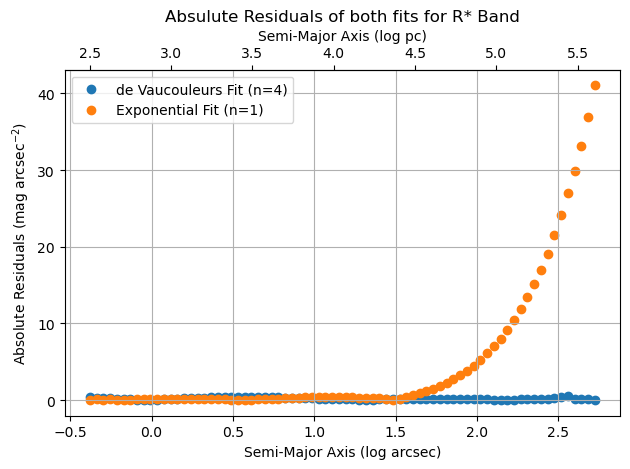



 Final Results:
[Exponential] r_eff = 20.04 ± 0.15 arcsec
[Exponential] r_eff = 357.08 ± 2.74 pc
[de Vaucouleurs] r_eff = 366.16 ± 0.15 arcsec
[de Vaucouleurs] r_eff = 6523.80 ± 2.74 pc


In [9]:
fil_df = ellipse_df.loc[ellipse_df['filter'] == 'R*']

# clean
fil_df = fil_df[(fil_df['sma'] > 0) & (fil_df['intens'] > 0) & (fil_df['intens_err'] > 0)].copy()

# r_eff find thing
amplitude, r_eff = find_half_light(fil_df)
vl = models.Sersic1D(amplitude, r_eff, n=4, bounds={"r_eff": (0.1, fil_df['sma'].max())})
vl.n.fixed = True
ex = models.Sersic1D(amplitude, r_eff, n=1, bounds={"r_eff": (0.1, fil_df['sma'].max())})
ex.n.fixed = True

# Fit the model
fitter = fitting.LevMarLSQFitter()

weights = 1 / fil_df['intens_err']  # gives more weight to high SNR points
fitted_ex = fitter(ex, fil_df['sma'], fil_df['intens'], weights=weights)
fitted_vl = fitter(vl, fil_df['sma'], fil_df['intens'], weights=weights)
# Plot
r_fit = np.linspace(np.min(fil_df['sma']), np.max(fil_df['sma']), 500)
I_fit_vl = fitted_vl(r_fit)
I_fit_ex = fitted_ex(r_fit)


# Create Plots
ZP = sols['R'][0] 
pixscale = 0.5

# Convert to Mag
mu_fit_vl = count_to_mag(I_fit_vl, ZP)
mu_fit_ex = count_to_mag(I_fit_ex, ZP)

# Compare loss
resid_vl = fil_df['mu'] - count_to_mag(fitted_vl(fil_df['sma']), ZP)
resid_ex = fil_df['mu'] - count_to_mag(fitted_ex(fil_df['sma']), ZP)

mae_vl = np.mean(np.abs(resid_vl))
mae_ex = np.mean(np.abs(resid_ex))


sma_plt = np.log(fil_df['sma'])
mu_plt = fil_df['mu']
mu_err_low = fil_df['mu'] - fil_df['mu_err']
mu_err_high = fil_df['mu'] + fil_df['mu_err']

r_fit_plt = np.log(r_fit)

# Plot in mag space
plt.figure(figsize=(6, 4))
plt.plot(sma_plt, mu_plt, 'o', label='Data')
plt.plot(np.log(r_fit), mu_fit_vl, '-', label='de Vaucouleurs Fit (n=4)')
plt.plot(np.log(r_fit), mu_fit_ex, '-', label='Exponential Fit (n=1)')

plt.fill_between(sma_plt, mu_err_low, mu_err_high, alpha=0.3)

plt.xlabel("Semi-Major Axis (log arcsec)")
sec = plt.gca().secondary_xaxis('top', functions=(log_arcsec_to_log_pc, log_pc_to_log_arcsec))
sec.set_xlabel("Semi Major Axis (log pc)", fontsize=10)

plt.ylabel(r"Surface Brightness (mag arcsec$^{-2}$)")
plt.ylim(None, 40)
plt.gca().invert_yaxis()  # Magnitudes: brighter = lower

plt.legend()
plt.title(f"Surface Brightness Profile Fit for R* Band")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print specs
print(f"de Vaucoulers MAE: {mae_vl}")
print(f"Fitted de Vaucoulers I_e (amplitude): {fitted_vl.amplitude.value:.2f}")
print(f"Fitted de Vaucoulers R_e (scale length): {fitted_vl.r_eff.value:.2f}")
print(f"Fitted de Vaucoulers R_e (scale length, pc): {arcsec_to_pc(fitted_vl.r_eff.value):.2f}")

print(f"Exponential MAE: {mae_ex}")
print(f"Fitted Exponential I_e (amplitude): {fitted_ex.amplitude.value:.2f}")
print(f"Fitted Exponential R_e (scale length): {(fitted_ex.r_eff.value/ 1.678):.2f}")
print(f"Fitted Exponential R_e (scale length, pc): {arcsec_to_pc(fitted_ex.r_eff.value/ 1.678):.2f}")

# Plot Residuals
plt.scatter(np.log10(fil_df['sma']), abs(resid_vl), label='de Vaucouleurs Fit (n=4)')
plt.scatter(np.log10(fil_df['sma']), abs(resid_ex), label='Exponential Fit (n=1)')
plt.xlabel("Semi-Major Axis (log arcsec)")

sec = plt.gca().secondary_xaxis('top', functions=(log_arcsec_to_log_pc, log_pc_to_log_arcsec))
sec.set_xlabel("Semi-Major Axis (log pc)", fontsize=10, fontweight='normal')
plt.ylabel(r"Absolute Residuals (mag arcsec$^{-2}$)")
plt.legend()
plt.title(f"Absulute Residuals of both fits for R* Band")
plt.grid(True)
plt.tight_layout()
plt.show()

# Covariance matrix extraction
print("\n\n Final Results:")
param_cov = fitter.fit_info['param_cov']
if param_cov is not None:
    idx_ex = fitted_ex.param_names.index('r_eff')
    err_r_eff_ex = np.sqrt(param_cov[idx_ex, idx_ex])
    print(f"[Exponential] r_eff = {fitted_ex.r_eff.value:.2f} ± {err_r_eff_ex:.2f} arcsec")
    print(f"[Exponential] r_eff = {arcsec_to_pc(fitted_ex.r_eff.value):.2f} ± {arcsec_to_pc(err_r_eff_ex):.2f} pc")

    idx_vl = fitted_vl.param_names.index('r_eff')
    err_r_eff_vl = np.sqrt(param_cov[idx_vl, idx_vl])
    print(f"[de Vaucouleurs] r_eff = {fitted_vl.r_eff.value:.2f} ± {err_r_eff_vl:.2f} arcsec")
    print(f"[de Vaucouleurs] r_eff = {arcsec_to_pc(fitted_vl.r_eff.value):.2f} ± {arcsec_to_pc(err_r_eff_vl):.2f} pc")
else:
    print("Covariance matrix unavailable — fit may not have converged well.")
